# Investigate Wind Direction

In [7]:
import xarray as xr
import matplotlib.pyplot as plt
import math
import numpy as np
import cartopy.crs as ccrs
import geopandas as gpd

In [8]:
ds = xr.open_dataset("../output/grids/a3d_grids.nc")

# Plot wind speed and direction from Alpine-3D

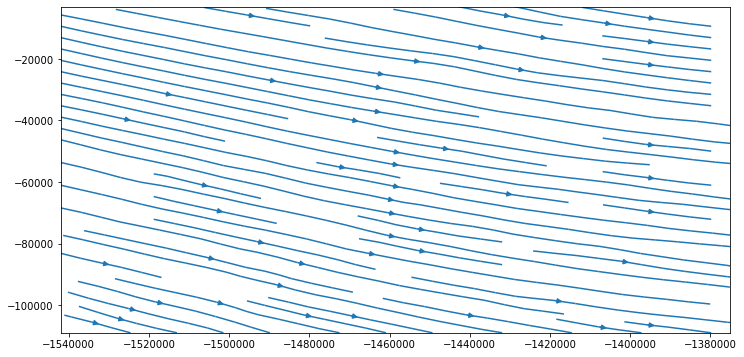

In [9]:
'''
Calculates U and V components of wind from wind speed and direction. 
Wind direction is the meteorological wind direction (i.e. direction the wind is coming from in degrees)
'''
def calc_U_V(speed, direction):
    U = -speed * np.sin(math.pi / 180 * direction)
    V = -speed * np.cos(math.pi / 180 * direction)
    return U, V

# Get U and V components
U, V = calc_U_V(ds['ws'], ds['dw'])

# Get lat/lon
x_snowpack = ds['easting']
y_snowpack = ds['northing']

# Plot map of mean wind
plt.figure(figsize=(12,6))
space = 10
plt.streamplot(x_snowpack.values, y_snowpack.values, U.mean(dim='time'), V.mean(dim='time'))

<xarray.DataArray 'dw' ()>
array(285.79297, dtype=float32)
Coordinates:
    northing  float32 -59000.0
    easting   float32 -1492000.0


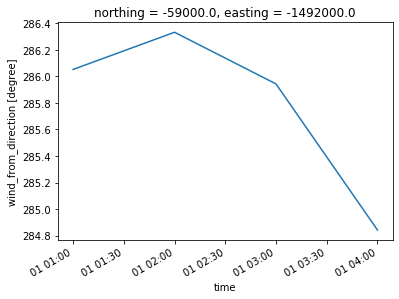

In [10]:
ds['dw'][:,50,50].plot()
print(ds['dw'][:,50,50].mean()) # this is wrong... But it gives a first look at wind direction. 

# The mean wind direction is generally from the northeast (upper left side of figure) in Alpine 3D. But RACMO2 says the wind is from the north..
## Is MERRA-2 in agreement with Alpine-3D, or does Alpine-3D have a processing error? Or is the Liston algorithm wrong?

U mean: -1.1336934436912385
V mean: -9.017110922452282


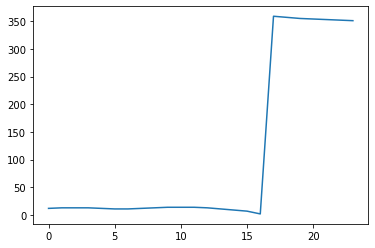

In [11]:
# This is from the .smet files created by meteoio.
# This picture is generally consistent with what comes out of A3D (Liston algorithm). So maybe going from MERRA-2 to .smet is incorrect? 
# smet_path = "/scratch/summit/erke2265/SNOWPACK_WAIS/input/meteo/A3D_site_33.smet"
smet_path = "/scratch/summit/erke2265/SNOWPACK_WAIS/snowpack/Scripts/create_smet_from_netcdf/output/VIR33.smet"
VW_smet, DW_smet = np.loadtxt(smet_path, skiprows=16, usecols=(3,4), unpack=True)
U_smet, V_smet = calc_U_V(VW_smet, DW_smet)
print("U mean: " + str(U_smet.mean()))
print("V mean: " + str(V_smet.mean()))
plt.plot(DW_smet[0:24])
#plt.plot(DW_smet)

(-10, 10)

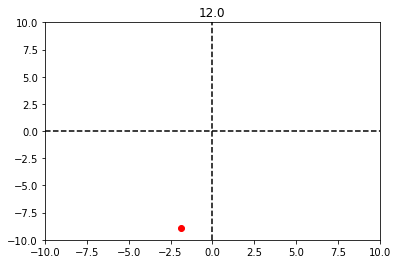

In [12]:
ind = 0
plt.plot(U_smet[ind], V_smet[ind], 'ro')
plt.plot([-10, 10], [0,0], 'k--')
plt.plot([0, 0], [-10,10], 'k--')
plt.title(str(DW_smet[ind]))
plt.xlim([-10, 10])
plt.ylim([-10, 10])

# Plot MERRA-2 1980 mean wind speed and direction

/projects/erke2265/miniconda/envs/alpine3d/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/projects/erke2265/miniconda/envs/alpine3d/lib/python3.6/site-packages/cartopy/vector_transform.py:140: UserWarning: Some vectors at source domain corners may not have been transformed correctly
  u, v = target_proj.transform_vectors(src_crs, x, y, u, v)


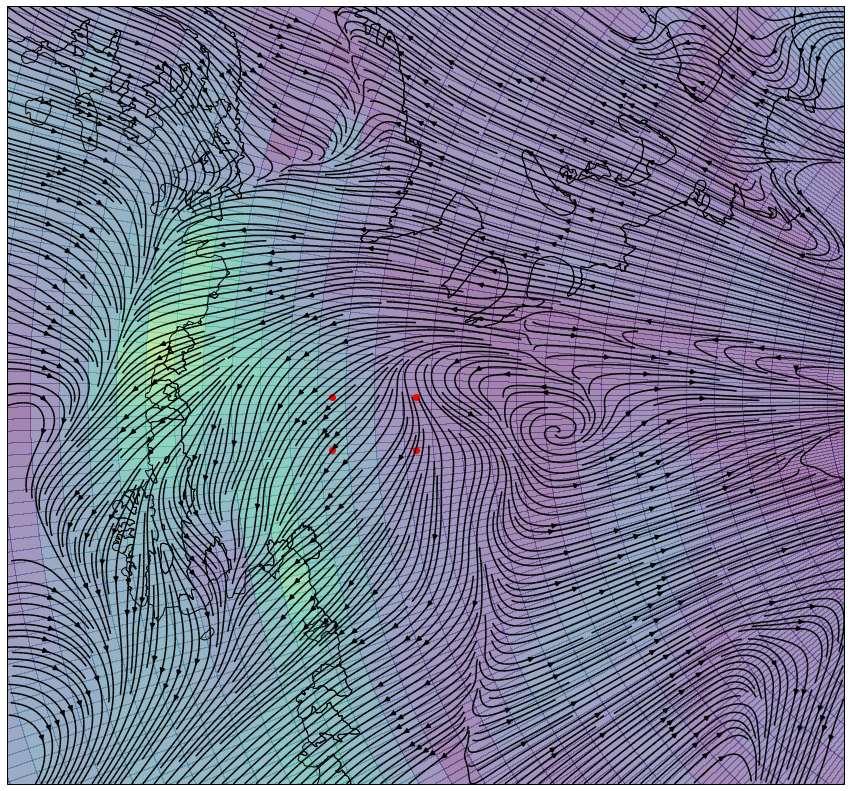

In [7]:
# Define upper left and lower right A3D domain corners in epsg 3031
ncol = 168
nrow = 107
left = -1542000 # done
bottom = -109000 # done
top = bottom + 1000 * (nrow -1)
right = left + 1000 * (ncol -1)

# Look at MERRA-2
M2_U_path = "/scratch/summit/erke2265/MERRA2/U10M_hourly_1980.nc"
M2_V_path = "/scratch/summit/erke2265/MERRA2/V10M_hourly_1980.nc"

# Mean U and V components
M2_U = xr.open_dataset(M2_U_path)
M2_U = M2_U['U10M']
M2_U_mean = M2_U[0,:,:].values
# M2_U_mean = M2_U.mean(dim='time').values

M2_V = xr.open_dataset(M2_V_path)
M2_V = M2_V['V10M']
M2_V_mean = M2_V[0,:,:].values
# M2_V_mean = M2_V.mean(dim='time').values

# Calculate mean wind speed.
ws_mean = np.sqrt( np.power(M2_U_mean,2) + np.power(M2_V_mean,2))

# Load coastlines
df = gpd.read_file("/pl/active/nasa_smb/Data/ADD_Coastline_low_res_polygon.shp")
crs_epsg = ccrs.SouthPolarStereo()
df_epsg = df.to_crs(epsg='3031')

# Generate figure 
fig, axs = plt.subplots(1, 1, subplot_kw={'projection': crs_epsg},
                        figsize=(15, 15))

# Plot coastlines
# axs.set_extent((-180, 180, -90, -60), ccrs.PlateCarree())
axs.set_extent((-110, -70, -85, -70), ccrs.PlateCarree())
axs.add_geometries(df_epsg['geometry'], crs=crs_epsg,
                      facecolor='none', edgecolor='black')

# Plot winds
vector_crs = ccrs.PlateCarree()
space = 1
axs.pcolor(M2_U['lon'].values, M2_U['lat'].values, ws_mean, transform=vector_crs, alpha=0.5)
streamlines = axs.streamplot(M2_U['lon'].values, M2_U['lat'].values, M2_U_mean, \
            M2_V_mean, color='k', transform=vector_crs, density=5)

# Plot model domain
plt.scatter(left, bottom, c='r', label="A3D Domain")
plt.scatter(left, top, c='r')
plt.scatter(right, bottom, c='r')
plt.scatter(right, top, c='r')